In [1]:
import sys
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter


df = pd.read_csv('merged_checked.csv')

# Funzione classica per il calcolo del Kappa


In [2]:
def inter_annotator_agreement(df, column_name, annotator1, annotator2):
    # Filter rows for the given annotators
    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    # Merge dataframes on the ID column
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    
    # Filter rows with non-missing values for the given column
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])

    # Rimuovo le righe vuote dal dataset degli annotatori, vanno bene le righe perché tanto c'è un valore solo
    merged_df = merged_df[merged_df[column_name+'_x'] != -1]
    merged_df = merged_df[merged_df[column_name+'_x'] != '-1']
    merged_df = merged_df[merged_df[column_name+'_y'] != -1]
    merged_df = merged_df[merged_df[column_name+'_y'] != '-1']
    
    agreement_score = cohen_kappa_score(merged_df[column_name+'_x'], merged_df[column_name+'_y'])
    
    print('Kappa tra ' + annotator1 + ' e ' + annotator2 + ' per ' + column_name + ': ' + str(agreement_score))




# Q 1.1 

Q1.1: What type of news article are you reviewing? (Check one): <br>
    1.  Straight news, or 'hard news' <br>
    2.  Editorial/opinion <br>
    3.  Feature/investigation <br>
    4.  Satire <br>
    5.  Lifestyle content, obituary, 'listicle', or other 'soft news' <br>


In [3]:
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.1', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.1', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.1', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.1: 0.6903472443453329
Kappa tra Manuel e Marinella per Q1.1: 0.7307060755336616
Kappa tra Angelo e Marinella per Q1.1: 0.8258518117901569
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.1: 0.19536670997705474
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.1: 0.19281271596406346
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.1: 0.2234433608402101


In [4]:

def custom_agreement(column_name,set1, set2):

    # Split the numbers
    set1 = set1.split(";")
    set2 = set2.split(";")

    # Verifica se entrambe le liste contengono almeno un 2
    if '2' in set1 and '2' in set2:
        # Verifica se i 2 sono nella stessa posizione
        if set1 == set2:
            return "Perfect Agreement (All correct)"
        # Verifica se nella seconda lista c'è almeno un 2 nella stessa posizione
        elif any(a == b == '2' for a, b in zip(set1, set2)):
            #print ('lista 1' +str(set1) + ' lista 2' + str(set2))
            return "Partial Agreement (Extra Incorrect)"
        else:
            return "No Agreement (All Incorrect)"
    else:
        return "No Agreement (All Incorrect)"


def discoverValues(df, column_name, annotator1, annotator2):
    # Creo l'oggetto per contare le divergenze
    divergences = Counter()

    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])
    
    perfect_agreement_count = 0
    partial_correct_count = 0

    partial_extra_count = 0
    no_agreement_count = 0
    
    for index, row in merged_df.iterrows():
        if (row[column_name+'_x'] != -1 and row[column_name+'_x'] != '-1'):
            agreement_category = custom_agreement(column_name,row[column_name+'_x'], row[column_name+'_y'])
            if agreement_category == 'Perfect Agreement':
                perfect_agreement_count += 1
            elif agreement_category == 'Partial Agreement (Some Correct)':
                partial_correct_count += 1
            elif agreement_category == 'Partial Agreement (Extra Incorrect)':
                partial_extra_count += 1
            elif agreement_category == 'No Agreement (All Incorrect)':
                no_agreement_count += 1

    print(annotator1 + ' e ' + annotator2 + ' per ' + column_name + ':')

    print('   Perfect Agreement:', perfect_agreement_count)
    if (column_name != 'Q1.1'):
        print('   Partial Agreement (Some Correct):', partial_correct_count)
    print('   Partial Agreement (Extra Incorrect):', partial_extra_count)
    print('   No Agreement (All Incorrect):', no_agreement_count)
    print('\n')


discoverValues(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')

Manuel e ChatGPT4AsAnnotator per Q1.1:
   Perfect Agreement: 0
   Partial Agreement (Extra Incorrect): 76
   No Agreement (All Incorrect): 50




In [5]:
def discoverValues(df, column_name, annotator1, annotator2):
    # Creo l'oggetto per contare le divergenze
    divergences = Counter()

    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])
    
    for index, row in merged_df.iterrows():
        if (row[column_name+'_x'] != -1 and row[column_name+'_x'] != '-1'):
            agreement_category = custom_agreement(column_name, row[column_name+'_x'], row[column_name+'_y'])
            if agreement_category == 'Partial Agreement (Extra Incorrect)':
                divergences[(tuple(row[column_name+'_x'].split(';')), tuple(row[column_name+'_y'].split(';')))] += 1

    # Ritorna i primi 10 casi più frequenti di divergenza
    return divergences.most_common(10)

# Modifica il chiamato di discoverValues per salvarne i risultati
divergences = discoverValues(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')
print("Casi più frequenti di divergenza tra la prima e la seconda lista:")
for divergence, count in divergences:
    print("Divergenza:", divergence, " - Frequenza:", count)

Casi più frequenti di divergenza tra la prima e la seconda lista:
Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 41
Divergenza: (('1', '1', '2', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 25
Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '1', '1', '2'))  - Frequenza: 5
Divergenza: (('1', '2', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 2
Divergenza: (('1', '1', '2', '1', '1'), ('1', '2', '2', '1', '1'))  - Frequenza: 1
Divergenza: (('1', '1', '2', '1', '1'), ('2', '1', '2', '1', '2'))  - Frequenza: 1
Divergenza: (('2', '1', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 1


# Q 1.2

Q1.2: How accurately does the story’s headline describe the content of the story? (Check one): <br>
    1.  Extremely inaccurately<br>
    2.  Somewhat inaccurately<br>
    3.  Somewhat accurately<br>
    4.  Extremely accurately<br>


In [6]:
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.2', 'Angelo', 'Marinella')
print ('-------------------------')
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.2: 0.4273594909862142
Kappa tra Manuel e Marinella per Q1.2: 0.3660504201680672
Kappa tra Angelo e Marinella per Q1.2: 0.493680731090803
-------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.2: 0.022283167637984325
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.2: 0.09428479173393611
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.2: 0.07331114509310055


##Rimuovo i valori estrami facendolo diventare un binario:

Q1.2: How accurately does the story’s headline describe the content of the story? (Check one):<br>
    1.  Inaccurately <br>
    4.  Accurately<br>


In [7]:
# Sostituisci i valori 3 con 4 e i valori 2 con 1 nella nuova colonna
df['Q1.2_binary'] = df['Q1.2'].replace({3: 4, 2: 1})

# Elimina i valori -1
df = df[df['Q1.2_binary'] != -1]

df['Q1.2_binary'].unique()


# df_filtered = df[df['annotator'] == 'Marinella']
# df_filtered['Q1.2_binary'].unique()

array([1, 4])

### Rifaccio il K

In [8]:
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.2_binary', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2_binary', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2_binary', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.2_binary: 0.452054794520548
Kappa tra Manuel e Marinella per Q1.2_binary: 0.3555992141453831
Kappa tra Angelo e Marinella per Q1.2_binary: 0.42827868852459017
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.2_binary: 0.0
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.2_binary: 0.0
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.2_binary: 0.0


Non so perché venga zero,questi sono i valori di Manuel e ChatGPT

merged_df[column_name+'_x'] = values: array([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 1, 1, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4,
       4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 1, 1, 4, 1, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 1, 4, 1, 1, 1, 1, 4])
       
       
       
merged_df[column_name+'_y'] =  _values: array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

# Q 1.3

Q1.3: Does the story’s headline contain any of the following elements? (Check all that apply):<br>
    1.  A proper noun<br>
    2.  A question<br>
    3.  A colon<br>
    4.  A quotation<br>
    5.  Words or phrases that are entirely capitalized (all caps)<br>
    6.  The pronoun 'this'<br>
    7.  Generalizing terms (ex: 'never', 'always')<br>
    8.  Explanation phrases, such as 'Here’s why...'<br>
    9.  Hyperbolic, emotional or sensationalized language<br>


In [9]:
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.3', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.3', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.3', 'Angelo', 'ChatGPT4AsAnnotator')

Kappa tra Manuel e Angelo per Q1.3: 0.6364697301239971
Kappa tra Manuel e Marinella per Q1.3: 0.6893732970027248
Kappa tra Angelo e Marinella per Q1.3: 0.6365628423853498
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.3: 0.04392177246442719
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.3: 0.09255643685173887
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.3: 0.08964966031703747


In [11]:
df['Q1.3'].unique

<bound method Series.unique of 0         3
1       1;3
2       1;3
3       1;3
4         3
       ... 
1014      1
1015      1
1016      1
1017    1;5
1018    1;9
Name: Q1.3, Length: 1018, dtype: object>

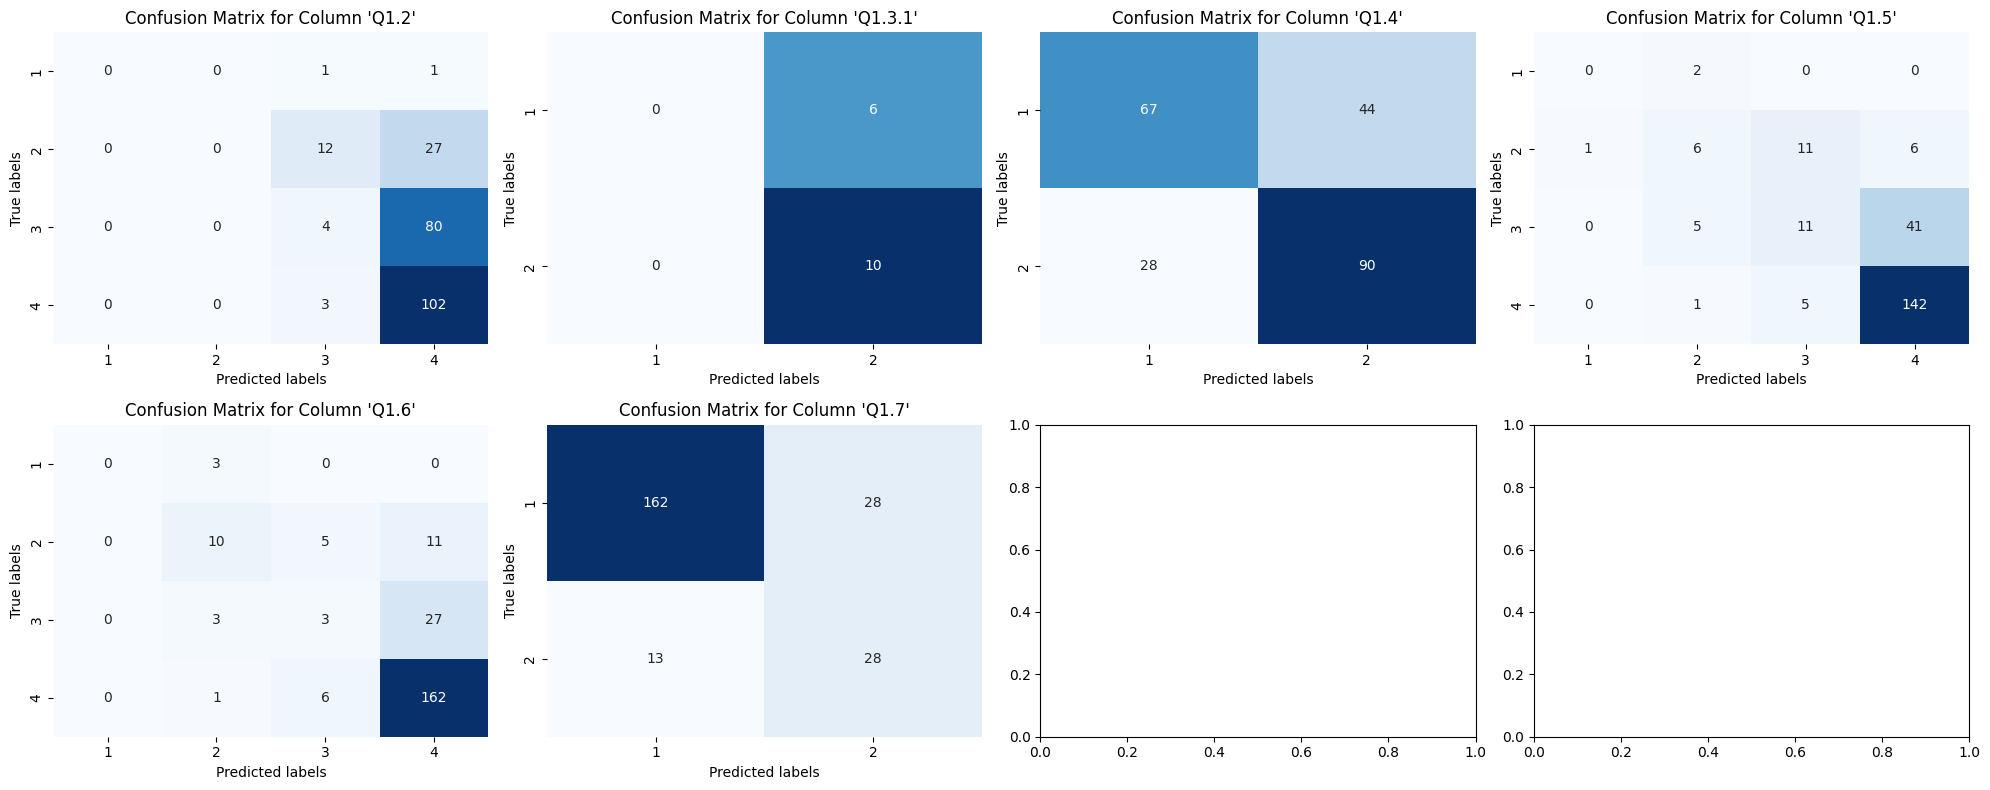

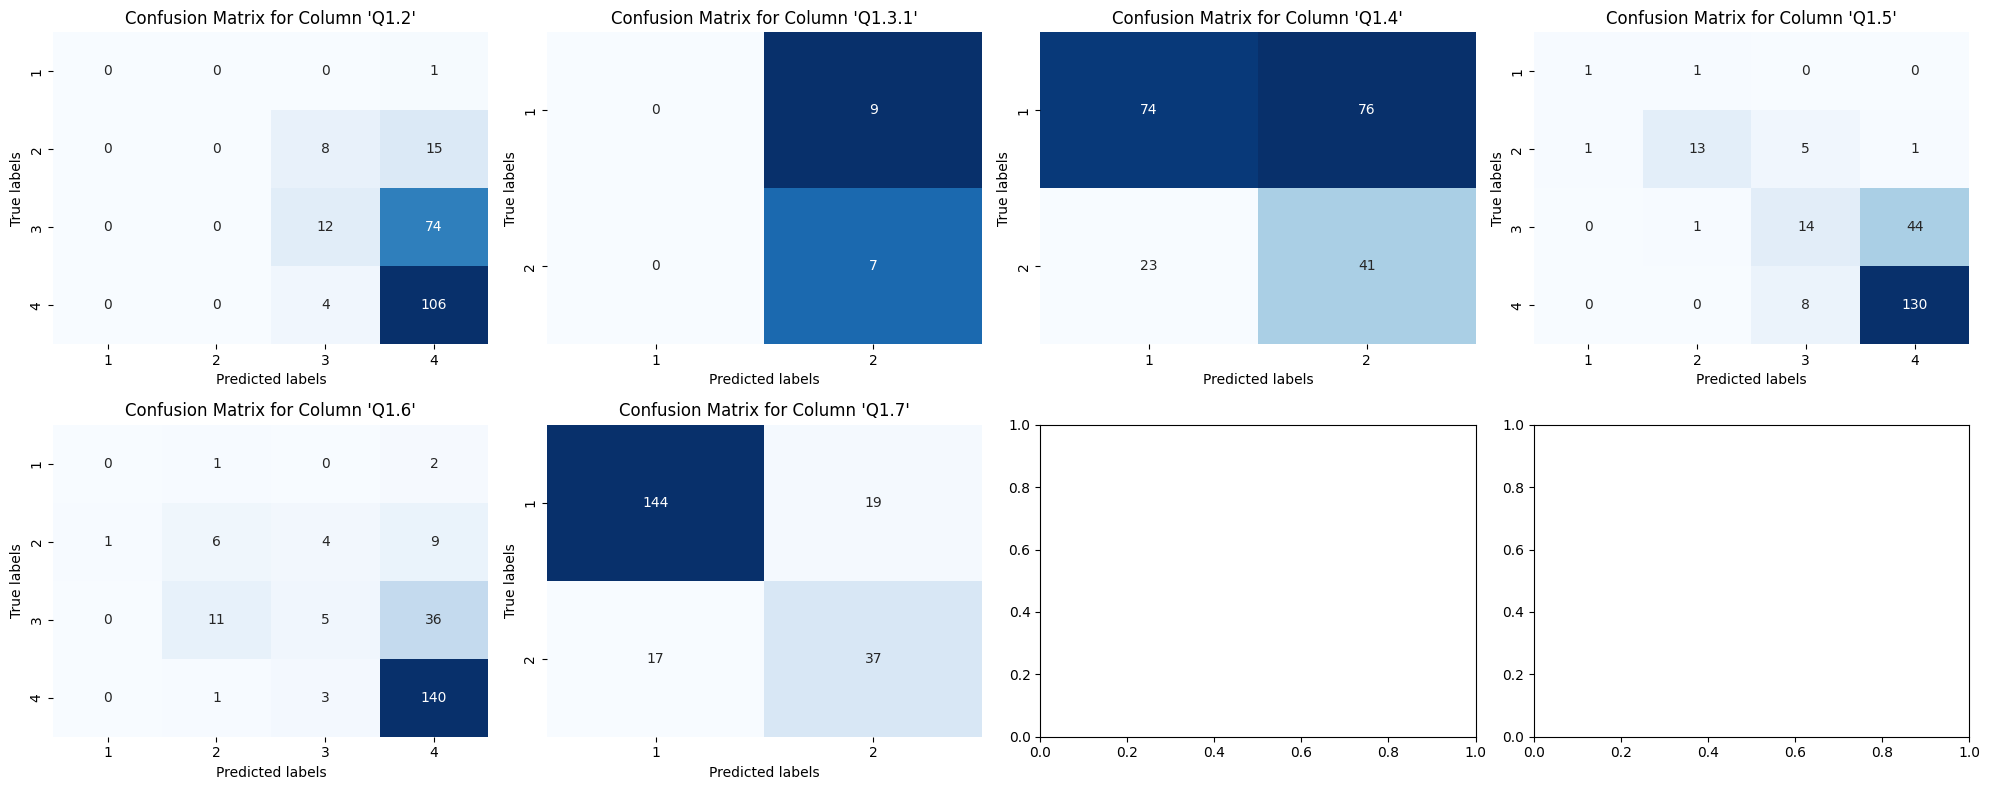

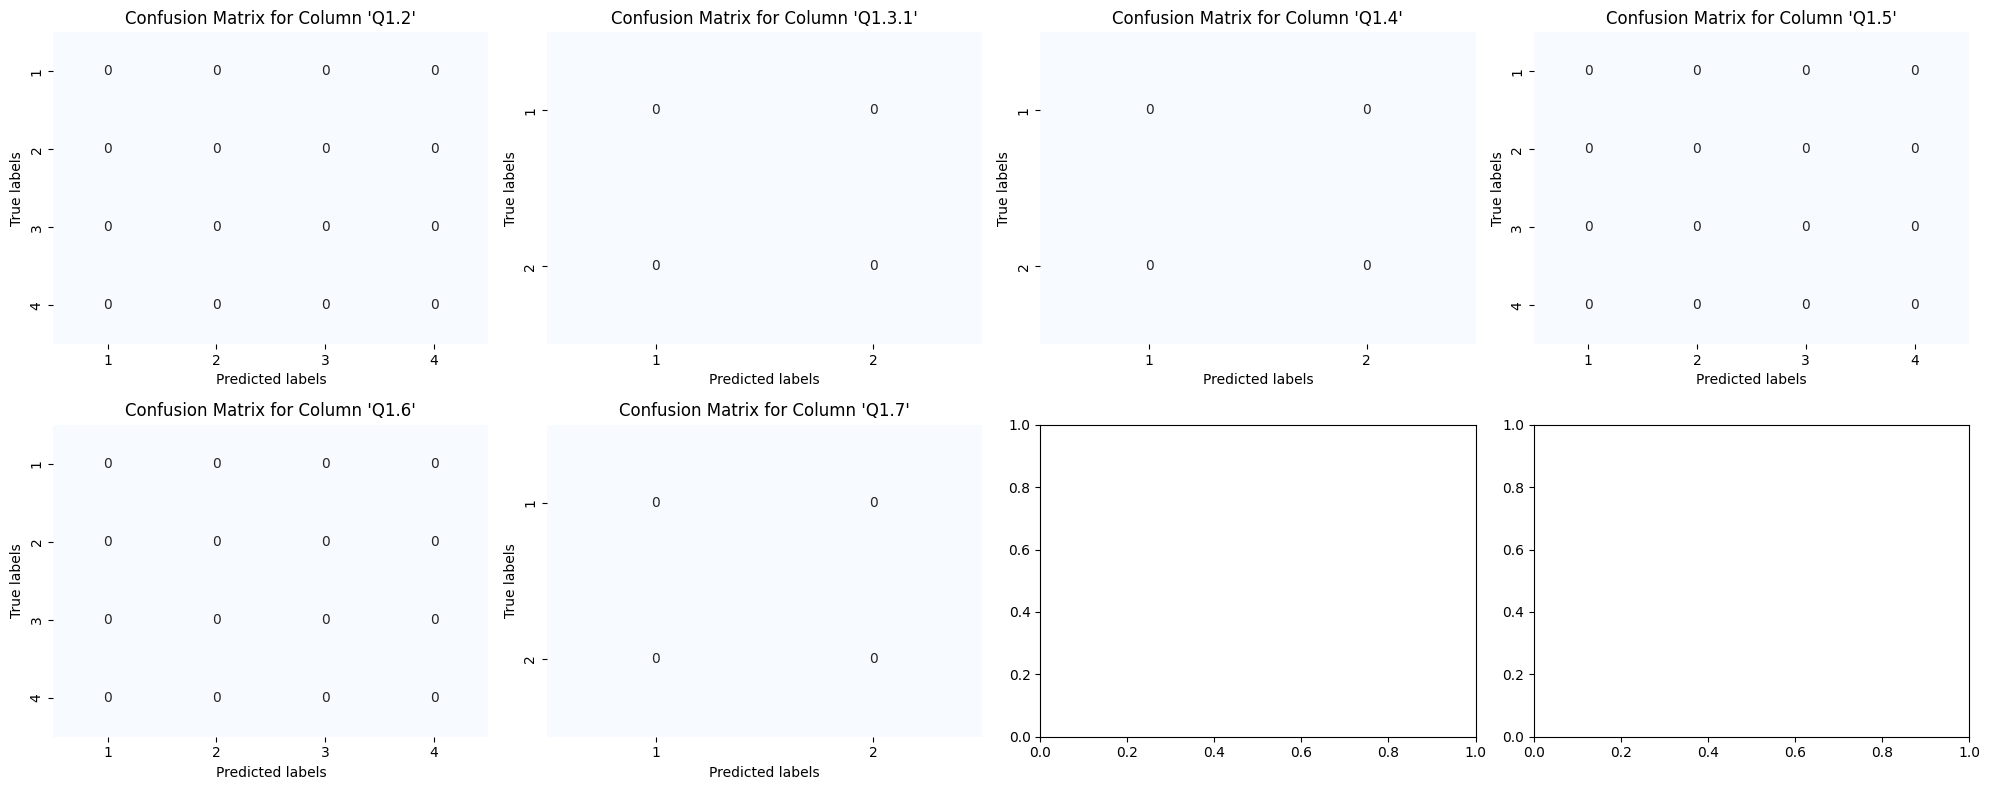

In [6]:
def calculate_confusion_matrix(annotator_1, annotator_2, columns, possible_values):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred, labels=possible_values[column])
    plot_confusion_matrices(confusion_matrices, possible_values)
    return 0

def plot_confusion_matrices(conf_matrices, possible_values):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4
        col = i % 4
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col], 
                    xticklabels=possible_values[column], yticklabels=possible_values[column])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()


columns_to_consider = ["Q1.2", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7"]
possible_values = {
    'Q1.2': ['1', '2', '3', '4'],
    'Q1.3.1': ['1', '2'],
    'Q1.4': ['1', '2'],
    'Q1.5': ['1', '2', '3', '4'],
    'Q1.6': ['1', '2', '3', '4'],
    'Q1.7': ['1', '2'],
}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)

conf_matrices = calculate_confusion_matrix('Marinella','ChatGPT4AsAnnotator', columns_to_consider, possible_values)

conf_matrices = calculate_confusion_matrix('Fabio','ChatGPT4AsAnnotator', columns_to_consider, possible_values)